In [15]:
import sys, os, time
import numpy as np
import pandas as pd
import pickle

from sklearn.preprocessing import label_binarize

parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(parent_dir)

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from estimators.statistical_descriptor import Nagler_WS
# from plot.figure_roc import ROC_plot
from utils.dataset_management import load_train, load_test, parser_pipeline, BFold
from utils.dataset_load import  save_h5_II, load_data_h5, load_info_h5, shuffle_data, Dataset_loader
from utils.fold_management import fold_management
from utils.label_management import label_management
from utils.files_management import (
    load_yaml,
    dump_pkl,
    init_logger,
    open_param_set_dir,
    report_prediction,
    report_metric_from_log,
    write_report
)


SyntaxError: f-string: unmatched '[' (files_management.py, line 343)

In [17]:
!pip install yaml

ERROR: Could not find a version that satisfies the requirement yaml (from versions: none)
ERROR: No matching distribution found for yaml


In [9]:
with open('../results/study_050624_11H56M36_crocus_mFold/metrics_tmp.pkl', 'rb') as f:
    data = pickle.load(f)
data

{'KNN_direct': [{'f1_score_macro': 79.10000000000001,
   'f1_score_weighted': 79.63,
   'accuracy_score': 79.94,
   'precision_score_macro': 80.55,
   'recall_score_macro': 78.66,
   'roc_auc_score': 78.66,
   'log_loss': 57.699999999999996,
   'kappa_score': 58.45,
   'confusion_matrix':          0        1
   0  88.8889  11.1111
   1  31.5615  68.4385,
   'y_true': array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0,
          0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
          0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
          0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,
          1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1,
          0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0,
          0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0,
          0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1,
          1, 0, 0, 1, 1, 

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import auc, roc_curve
import numpy as np
import pandas as pd
import os

def create_plots(metrics_dict, save_dir="plots"):
    """
    Create boxplots and ROC curves from the metrics dictionary and save them as individual files.

    Parameters
    ----------
    metrics_dict : dict
        Dictionary containing various computed metrics for multiple models.
    save_dir : str
        Directory where the plots will be saved.
    """
    
    # Create directory if it does not exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    

    # Create and save ROC curve plots for each class
    for model_name, metrics_list in metrics_dict.items():
        for fold_metrics in metrics_list:
            y_true = fold_metrics['y_true']
            y_pred = fold_metrics['y_pred']
            all_labels = np.unique(y_true)

            for class_label in all_labels:
                plt.figure(figsize=(12, 8))
                fpr, tpr, _ = roc_curve(y_true == class_label, y_pred[:, class_label])
                roc_auc = auc(fpr, tpr)
                plt.plot(fpr, tpr, label=f'Class {class_label} (AUC = {roc_auc:.2f})')
                plt.plot([0, 1], [0, 1], 'k--')
                plt.xlabel('False Positive Rate')
                plt.ylabel('True Positive Rate')
                plt.title(f'ROC Curve for Class {class_label} - Model {model_name}')
                plt.legend(loc='best')
                plt.tight_layout()
                plt.savefig(os.path.join(save_dir, f'roc_curve_class_{class_label}_model_{model_name}.png'))
                plt.close()

    # Create and save the average ROC curve
    plt.figure(figsize=(12, 8))
    for model_name, metrics_list in metrics_dict.items():
        mean_fpr = np.linspace(0, 1, 100)
        mean_tpr = np.zeros_like(mean_fpr)
        
        for fold_metrics in metrics_list:
            y_true = fold_metrics['y_true']
            y_pred = fold_metrics['y_pred']
            all_labels = np.unique(y_true)

            for class_label in all_labels:
                fpr, tpr, _ = roc_curve(y_true == class_label, y_pred[:, class_label])
                mean_tpr += np.interp(mean_fpr, fpr, tpr)
        
        mean_tpr /= (len(all_labels) * len(metrics_list))
        mean_auc = auc(mean_fpr, mean_tpr)
        
        plt.plot(mean_fpr, mean_tpr, label=f"{model_name} (Mean AUC = {mean_auc:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curves')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'average_roc_curves.png'))
    plt.close()


In [27]:
def plot_roc_curve(y_true, y_probas, title='ROC Curves',
                   curves=('micro', 'macro', 'each_class'),
                   ax=None, figsize=None, cmap='nipy_spectral',
                   title_fontsize="large", text_fontsize="medium",
                   save_path=None):
    """Generates the ROC curves from labels and predicted scores/probabilities

    Args:
        y_true (array-like, shape (n_samples)): Ground truth (correct) target values.
        y_probas (array-like, shape (n_samples, n_classes)): Prediction probabilities for each class returned by a classifier.
        title (string, optional): Title of the generated plot. Defaults to "ROC Curves".
        curves (array-like): A listing of which curves should be plotted on the resulting plot. Defaults to `("micro", "macro", "each_class")`
                             i.e. "micro" for micro-averaged curve, "macro" for macro-averaged curve
        ax (:class:`matplotlib.axes.Axes`, optional): The axes upon which to plot the curve. If None, the plot is drawn on a new set of axes.
        figsize (2-tuple, optional): Tuple denoting figure size of the plot e.g. (6, 6). Defaults to ``None``.
        cmap (string or :class:`matplotlib.colors.Colormap` instance, optional): Colormap used for plotting the projection. View Matplotlib Colormap
                                                                                 documentation for available options. https://matplotlib.org/users/colormaps.html
        title_fontsize (string or int, optional): Matplotlib-style fontsizes. Use e.g. "small", "medium", "large" or integer-values. Defaults to "large".
        text_fontsize (string or int, optional): Matplotlib-style fontsizes. Use e.g. "small", "medium", "large" or integer-values. Defaults to "medium".
        save_path (string, optional): Path to save the plot. If None, the plot is not saved. Defaults to ``None``.

    Returns:
        ax (:class:`matplotlib.axes.Axes`): The axes on which the plot was drawn.
    """
    y_true = np.array(y_true)
    y_probas = np.array(y_probas)

    if 'micro' not in curves and 'macro' not in curves and 'each_class' not in curves:
        raise ValueError('Invalid argument for curves as it only takes "micro", "macro", or "each_class"')

    classes = np.unique(y_true)
    probas = y_probas

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true, probas[:, i], pos_label=classes[i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    y_true_binarized = label_binarize(y_true, classes=classes)
    if len(classes) == 2:
        y_true_binarized = np.hstack((1 - y_true_binarized, y_true_binarized))

    fpr['micro'], tpr['micro'], _ = roc_curve(y_true_binarized.ravel(), probas.ravel())
    roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(len(classes)):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= len(classes)

    fpr['macro'] = all_fpr
    tpr['macro'] = mean_tpr
    roc_auc['macro'] = auc(fpr['macro'], tpr['macro'])

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)

    ax.set_title(title, fontsize=title_fontsize)

    if 'each_class' in curves:
        for i in range(len(classes)):
            color = plt.cm.get_cmap(cmap)(float(i) / len(classes))
            ax.plot(fpr[i], tpr[i], lw=2, color=color,
                    label='ROC curve of class {0} (area = {1:0.2f})'
                          ''.format(classes[i], roc_auc[i]))

    if 'micro' in curves:
        ax.plot(fpr['micro'], tpr['micro'],
                label='micro-average ROC curve (area = {0:0.2f})'.format(roc_auc['micro']),
                color='deeppink', linestyle=':', linewidth=4)

    if 'macro' in curves:
        ax.plot(fpr['macro'], tpr['macro'],
                label='macro-average ROC curve (area = {0:0.2f})'.format(roc_auc['macro']),
                color='navy', linestyle=':', linewidth=4)

    ax.plot([0, 1], [0, 1], 'k--', lw=2)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=text_fontsize)
    ax.set_ylabel('True Positive Rate', fontsize=text_fontsize)
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc='lower right', fontsize=text_fontsize)

    plt.savefig(save_path, bbox_inches='tight')
    
    return ax

In [48]:
def plot_model_roc_curves(models_dict, title_fontsize="large", text_fontsize="medium", save_path=None):
    """
    Generates separate ROC curves for each model in the dictionary.

    Args:
        models_dict (dict): A dictionary where keys are model names and values are lists of dictionaries containing
                            'y_true' and 'y_pred' for each fold.
        title_fontsize (string or int, optional): Matplotlib-style fontsizes for titles. Defaults to "large".
        text_fontsize (string or int, optional): Matplotlib-style fontsizes for text. Defaults to "medium".
        cmap (string or :class:`matplotlib.colors.Colormap` instance, optional): Colormap used for plotting. Defaults to 'nipy_spectral'.
        save_path (string, optional): Path to save the plot. If None, the plot is not saved. Defaults to None.

    Returns:
        None
    """
    for model_name, results in models_dict.items():
        try:
            plt.figure(figsize=(10, 8))

            mean_fpr = np.linspace(0, 1, 100)
            mean_tprs = []

            for fold_data in results:
                y_true = np.array(fold_data['y_true'])
                y_probas = np.array(fold_data['y_pred'])

                classes = np.unique(y_true)
                probas = y_probas

                for i in range(len(classes)):
                    fpr, tpr, _ = roc_curve(y_true, probas[:, i], pos_label=classes[i])
                    mean_tpr = np.interp(mean_fpr, fpr, tpr)
                    mean_tpr[0] = 0.0
                    mean_tprs.append(mean_tpr)

            mean_tpr = np.mean(mean_tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = auc(mean_fpr, mean_tpr)

            plt.plot(mean_fpr, mean_tpr, color='blue', lw=2, label='Average ROC curve (area = {0:0.2f})'.format(mean_auc))

            for fold_data in results:
                y_true = np.array(fold_data['y_true'])
                y_probas = np.array(fold_data['y_pred'])

                classes = np.unique(y_true)
                probas = y_probas

                for i in range(len(classes)):
                    fpr, tpr, _ = roc_curve(y_true, probas[:, i], pos_label=classes[i])
                    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'Class {classes[i]} fold {fold_data["fold"]} ROC curve')

            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate', fontsize=text_fontsize)
            plt.ylabel('True Positive Rate', fontsize=text_fontsize)
            plt.title(f'Receiver Operating Characteristic for {model_name}', fontsize=title_fontsize)
            plt.legend(loc='lower right', fontsize=text_fontsize)

            if save_path:
                plt.savefig(f"{save_path}_{model_name}.png", bbox_inches='tight')
                
            plt.show()
        except Exception as e:
            print(f"An error occurred while plotting ROC curves for model {model_name}: {e}")


In [49]:

tmp = data['KNN_direct'][0]

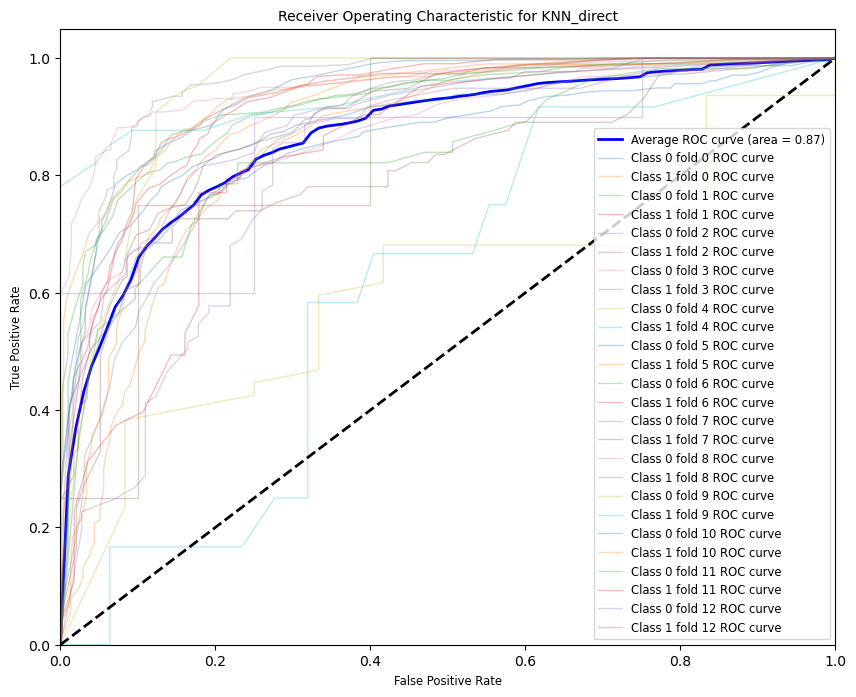

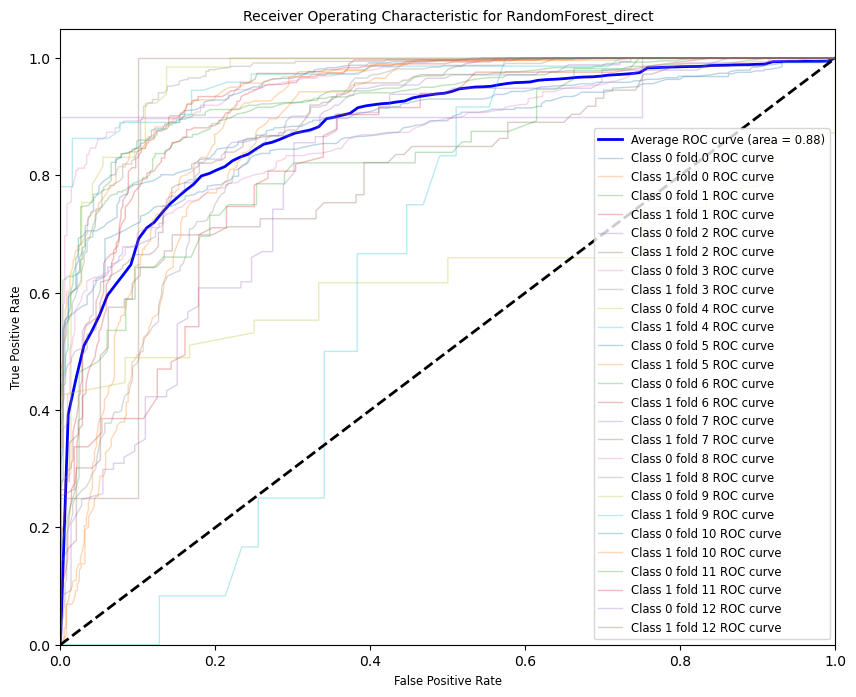

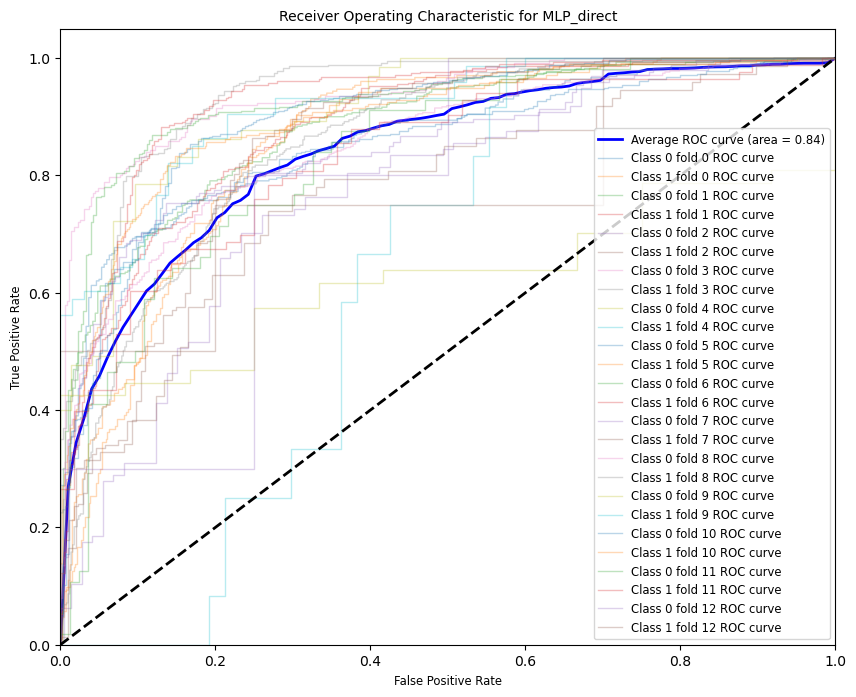

/home/listic/miniconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/listic/miniconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


An error occurred while plotting ROC curves for model SVMrbf_direct: 'numpy.float64' object does not support item assignment


<Figure size 1000x800 with 0 Axes>

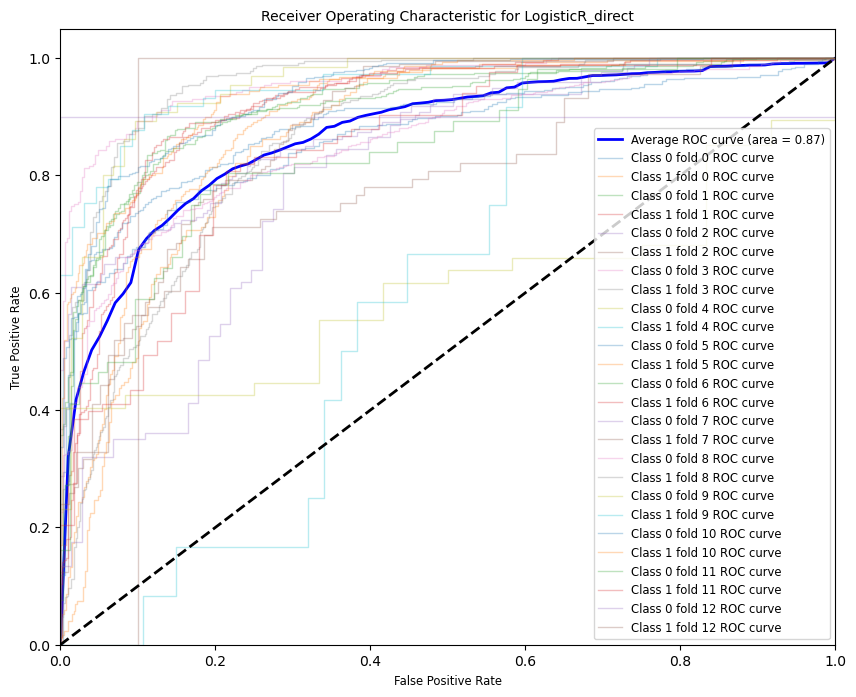

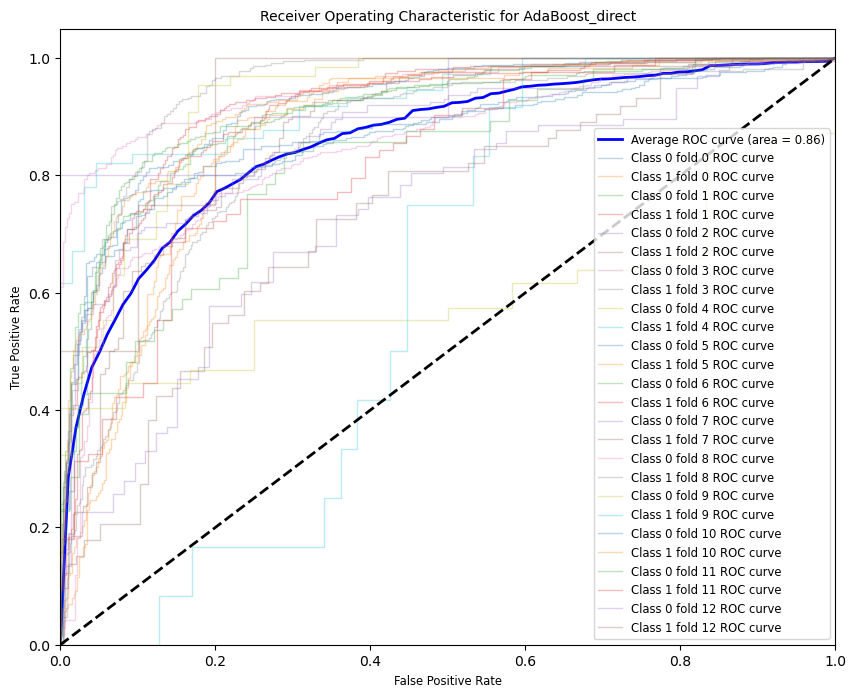

In [51]:
y_true = tmp["y_true"]
y_probas = tmp["y_pred"]
plot_model_roc_curves(data, cmap='nipy_spectral',
                   title_fontsize="medium", text_fontsize="small", save_path="./plots")
plt.show()

In [14]:
param_path = "../parameter/config_data_local.yml"
pipeline_param = load_yaml(param_path)

In [15]:
pipeline_param["generate_results"]

{'quantitative': {'f1_score': True,
  'weighted_F1_score': True,
  'roc_curves': True,
  'conf_matrix': True},
 'qualitative': {'maps': True, 'dates': ['15/05/2024', '31/01/2023']}}

In [31]:
param_path = "../parameter/config_pipeline.yml"
pipeline_param = load_yaml(param_path)

match pipeline_param["type"]:
    case "local":
        local_param_path = "../parameter/config_data_local.yml"
        data_param = load_yaml(local_param_path)
    case "global":
        global_param_path = "pipeline/parameter/config_data_global.yml"
        data_param = load_yaml(global_param_path)
    case _:
        f"no such type : {pipeline_param["type"]}"

try:
    data_path = "../data/dataset/dataset_AD_08200821_14Mas3Top3Phy_W15_corrected.h5"
    out_dir = pipeline_param["out_dir"]
    seed = pipeline_param["seed"]
    BANDS_MAX = pipeline_param["BANDS_MAX"]
except KeyError as e:
    print("KeyError: %s undefine" % e)

start_line = 0

# y_nagler = Nagler_estimation(data_path)
# print(y_nagler)

dtst_ld = Dataset_loader(
    data_path,
    shuffle=False,
)
dtst_ld.infos

KeyError: 'out_dir' undefine


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '../data/dataset/dataset_AD_08200821_14Mas3Top3Phy_W15_corrected.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [4]:
dtst_ld.infos[(dtst_ld.infos['tmin'] > 0) & (dtst_ld.infos['hsnow'] > 40)]

,date,massif,aquisition,aquisition2,elevation,slope,orientation,tmin,tel,hsnow
5632,2021-06-11,BELLEDONNE,ASC,ASC,2400.0,45.0,0.0,0.01,1.764194,45.176708
5639,2021-06-11,BELLEDONNE,ASC,ASC,2400.0,45.0,45.0,0.01,2.185814,59.180344
5640,2021-06-11,BELLEDONNE,ASC,ASC,2400.0,45.0,0.0,0.01,1.764194,45.176708
5648,2021-06-11,BELLEDONNE,ASC,ASC,2400.0,45.0,0.0,0.01,1.764194,45.176708
5650,2021-06-11,BELLEDONNE,ASC,ASC,2400.0,45.0,0.0,0.01,1.764194,45.176708
...,...,...,...,...,...,...,...,...,...,...
1283710,2021-05-29,GRANDES-ROUSSES,DSC,DSC,2400.0,45.0,45.0,0.01,1.595417,47.645008
1283719,2021-05-29,GRANDES-ROUSSES,DSC,DSC,2400.0,45.0,45.0,0.01,1.595417,47.645008
1283738,2021-05-29,GRANDES-ROUSSES,DSC,DSC,2400.0,45.0,45.0,0.01,1.595417,47.645008
1283759,2021-05-29,GRANDES-ROUSSES,DSC,DSC,2400.0,45.0,45.0,0.01,1.595417,47.645008


In [5]:
# Example of request
rq1 = "(date.dt.month == 3 and date.dt.day== 1) and ((elevation > 1000) and (elevation < 1750))"

x, y = dtst_ld.request_data(rq1)

Request: (date.dt.month == 3 and date.dt.day== 1) and ((elevation > 1000) and (elevation < 1750)) with 5861 samples
(5861, 15, 15, 9)


In [16]:
x.shape[1:]

(15, 15, 9)

In [6]:
np.unique(y["metadata"][:,1])

array(['ARAVIS', 'BAUGES', 'BEAUFORTAIN', 'BELLEDONNE', 'CHARTEUSE',
       'GRANDES-ROUSSES', 'HTE-MAURIE', 'HTE-TARENT', 'MAURIENNE',
       'MONT-BLANC', 'THABOR', 'VANOISE', 'VERCORS'], dtype='<U15')

In [7]:
fold =  fold_management(methode = "combinationFold", shuffle=False, random_state=42, train_aprox_size=0.80)
lab_man = label_management(methode = "crocus") 
targets = lab_man.transform(y)

In [8]:
np.unique(targets, return_counts=True)

(array([0, 1]), array([3355, 2506]))

In [9]:
fold.split(x, y)

<generator object combination_method at 0x7c51db461cc0>

In [10]:
for i, (train_index, test_index) in enumerate(fold.split(x, y)):

    print(f"Fold {i}:")

    print(f"    Train: index={train_index}")
    print(f"    Test:  index={test_index}")
    print(f"    distribution class train: {np.unique(targets[train_index], return_counts=True)}")
    print(f"    distribution class test: {np.unique(targets[test_index], return_counts=True)}")
    print(f"    train size: {len(train_index)/(len(train_index)+len(test_index))}")
    print(f"    massices in train {np.unique(y["metadata"][train_index,1])}")
    print(f"    massices in test {np.unique(y["metadata"][test_index,1])}")

Fold 0:
    Train: index=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,

In [28]:
for massive in (np.unique(y['metadata'][:, 1], return_counts=True)):
    print(massive[0] )

ARAVIS
828


In [11]:
massives_count = {}

for index, name in enumerate(y['metadata'][:, 1]):
    if name not in massives_count:
        massives_count[name] = {'count': 0, 'indices': []}
    massives_count[name]['count'] += 1
    
massives_count

{'BELLEDONNE': {'count': 615, 'indices': []},
 'MONT-BLANC': {'count': 386, 'indices': []},
 'HTE-MAURIE': {'count': 138, 'indices': []},
 'BAUGES': {'count': 770, 'indices': []},
 'HTE-TARENT': {'count': 139, 'indices': []},
 'MAURIENNE': {'count': 586, 'indices': []},
 'VANOISE': {'count': 688, 'indices': []},
 'BEAUFORTAIN': {'count': 741, 'indices': []},
 'VERCORS': {'count': 170, 'indices': []},
 'GRANDES-ROUSSES': {'count': 59, 'indices': []},
 'ARAVIS': {'count': 828, 'indices': []},
 'CHARTEUSE': {'count': 727, 'indices': []},
 'THABOR': {'count': 14, 'indices': []}}

In [12]:
massives_count = {}

for index, name in enumerate(y['metadata'][:, 1]):
    if name not in massives_count:
        massives_count[name] = {'count': 0, 'indices': []}
    massives_count[name]['count'] += 1
    massives_count[name]['indices'].append(index)

massives_count

{'BELLEDONNE': {'count': 615,
  'indices': [0,
   1,
   2,
   3,
   4,
   5,
   6,
   7,
   8,
   9,
   10,
   11,
   12,
   13,
   14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   25,
   26,
   27,
   28,
   29,
   30,
   31,
   32,
   33,
   34,
   35,
   36,
   37,
   38,
   39,
   40,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48,
   49,
   50,
   51,
   52,
   53,
   54,
   55,
   56,
   57,
   58,
   59,
   60,
   61,
   62,
   63,
   64,
   65,
   66,
   67,
   68,
   69,
   70,
   71,
   72,
   73,
   74,
   75,
   76,
   77,
   78,
   79,
   80,
   81,
   82,
   83,
   84,
   85,
   86,
   87,
   88,
   89,
   90,
   91,
   92,
   93,
   94,
   95,
   96,
   97,
   98,
   99,
   100,
   101,
   102,
   103,
   104,
   105,
   106,
   107,
   108,
   109,
   110,
   111,
   112,
   113,
   114,
   115,
   116,
   117,
   118,
   119,
   120,
   121,
   122,
   123,
   124,
   125,
   126,
   127,
   128,
   129,
   130,
   131,
   132,
   13